# 4.5 Calibrating a model

In this tutorial, you will learn how to manually calibrate an agent-based model.

## Problem 1

Plot the following data, and define a goodness of fit function for the following data for number of people infected on each timestep:

In [4]:
"""
Problem for Tutorial 4.5 Part 1
"""

# EXERCISE: Plot the data
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

data = np.array(
[ 7,  10,  16,  22,  26,  29,  35,  39,  48,  53,  59,  68,  77,
 85,  90,  95, 101, 107, 112, 124, 125, 129, 134, 137, 136, 135,
136, 134, 135, 137, 140, 140, 140, 142, 141, 137, 134, 129, 128,
126, 124, 125, 122, 118, 116, 114, 113, 109, 106, 105, 103,  99,
 96,  95,  92,  92,  92,  88,  88,  86,  84,  80,  80,  79,  79,
 76,  75,  72,  69,  68,  66,  66,  66,  66,  64,  61,  61,  61,
 61,  61,  60,  59,  58,  57,  57,  54,  49,  48,  47,  47,  47,
 47,  45,  45,  44,  44,  44,  44,  44,  41]
)
time = np.arange(len(data))*0.2 # 0.2 is the timestep

In [17]:
#fig, ax = plt.subplots(2)
#ax[0].pl.plot(time, data)
#plt.scatter(time, data, axes = ax[1])
pl.scatter(time, data, c = 'k')


SyntaxError: positional argument follows keyword argument (3463301265.py, line 4)

## Solution 1

In [ ]:
"""
Solution for Tutorial 4.5 Part 1
"""

fig = pl.figure()
pl.scatter(time, data, c='k')
pl.xlabel('Time')
pl.ylabel('Infections')

## Problem 2

We will calibrate the SIR model (beta and gamma) to some simple outbreak data.

**NOTE:** We will first define the mismatch function, then add the data and mismatch to the plot, and finally adjust the parameter values to get a good fit.

To calibrate the parameters, think about how `beta` and `dur_inf` affect the dynamics. Adjust them in order to get a better match to data (note that the fit won't be perfect). You can also adjust the `seed` to get a slightly different trajectory (different random noise).

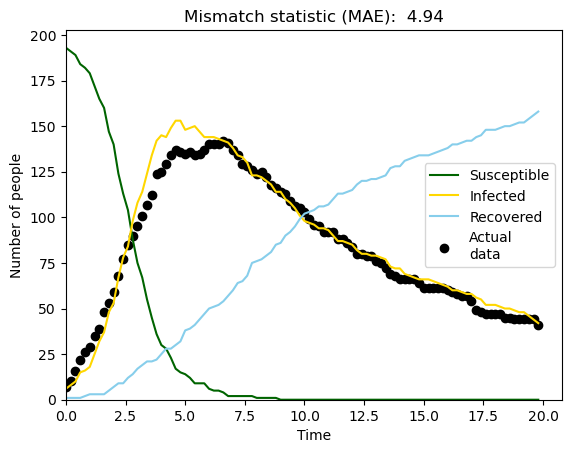

In [115]:
"""
Problem for tutorial 4.5 part 2
"""

import numpy as np
import sciris as sc
import pylab as pl

# EXERCISE 4 of 4 (do last): find parameters that match the data
beta = 0.3
dur_inf = 2
seed = 1

# Set default parameters
default_pars = sc.objdict(
    beta = beta, # Infection rate per contact per unit time
    dur_inf = dur_inf, # Average time of infection
    n_contacts = 5, # Number of people each person is connected to
    I0 = 5, # Number of people initially infected
    N = 200, # Total population size
    maxtime = 20, # How long to simulate for
    dt = 0.2, # Size of the timestep
    seed = seed, # Random seed to use
    colors = sc.objdict(S='darkgreen', I='gold', R='skyblue'),
)


# Define the data -- from sim.I.astype(int)
data = np.array(
[ 7,  10,  16,  22,  26,  29,  35,  39,  48,  53,  59,  68,  77,
 85,  90,  95, 101, 107, 112, 124, 125, 129, 134, 137, 136, 135,
136, 134, 135, 137, 140, 140, 140, 142, 141, 137, 134, 129, 128,
126, 124, 125, 122, 118, 116, 114, 113, 109, 106, 105, 103,  99,
 96,  95,  92,  92,  92,  88,  88,  86,  84,  80,  80,  79,  79,
 76,  75,  72,  69,  68,  66,  66,  66,  66,  64,  61,  61,  61,
 61,  61,  60,  59,  58,  57,  57,  54,  49,  48,  47,  47,  47,
 47,  45,  45,  44,  44,  44,  44,  44,  41]
)
time = np.arange(len(data))*default_pars.dt


class Person(sc.dictobj):
    """
    Define each person (agent) in SimpleABM

    They have three (mutually exclusive) states: susceptible (S), infected (I),
    recovered (R). They also have x,y coordinates for plotting.
    """

    def __init__(self, pars):
        self.pars = pars
        self.S = True # People start off susceptible
        self.I = False
        self.R = False

    def infect(self):
        self.S = False
        self.I = True

    def recover(self):
        self.I = False
        self.R = True

    def check_infection(self, other):
        pars = self.pars
        if self.S: # A person must be susceptible to be infected
            if other.I: # The other person must be infectious
                if np.random.rand() < pars.beta*pars.dt: # Infection is probabilistic
                    self.infect()

    def check_recovery(self):
        pars = self.pars
        if self.I: # A person must be infected to recover
            if np.random.rand() < pars.dt/pars.dur_inf: # Recovery is also probabilistic
                self.recover()


class Sim(sc.dictobj):
    """
    Define the simulation
    """

    def __init__(self, **kwargs):
        pars = sc.mergedicts(default_pars, kwargs) # Parameters to use
        pars.npts = int(pars.maxtime/pars.dt) # Number of points
        self.T = np.arange(pars.npts)
        self.time = self.T*pars.dt
        self.pars = pars
        self.initialize()

    def initialize(self):
        """ Initialize everything (sim can be re-initialized as well) """
        pars = self.pars

        # Initilaize people and the network
        np.random.seed(pars.seed)
        self.people = [Person(pars) for i in range(pars.N)] # Create all the people
        for person in self.people[0:pars.I0]: # Make the first I0 people infectious
            person.infect() # Set the initial conditions
        self.make_network()

        # Initial conditions
        self.S = np.zeros(pars.npts)
        self.I = np.zeros(pars.npts)
        self.R = np.zeros(pars.npts)
        self.S_full = []
        self.I_full = []
        self.R_full = []

    def make_network(self):
        """ Create a random network """
        pars = self.pars
        self.contacts = []
        for i in range(pars.N):
            partners = np.random.randint(pars.N, size=pars.n_contacts)
            pairs = [[i,j] for j in partners if i != j]
            self.contacts.extend(pairs)

    def check_infections(self):
        """ Check which agents become infected """
        for p1,p2 in self.contacts:
            person1 = self.people[p1]
            person2 = self.people[p2]
            person1.check_infection(person2)
            person2.check_infection(person1)

    def check_recoveries(self):
        """ Check which agents recover """
        for person in self.people:
            person.check_recovery()

    def count(self, t):
        """ Count the number of agents in each state """
        this_S = []
        this_I = []
        this_R = []
        for i,person in enumerate(self.people):
            if person.S: this_S.append(i)
            if person.I: this_I.append(i)
            if person.R: this_R.append(i)

        self.S[t] += len(this_S)
        self.I[t] += len(this_I)
        self.R[t] += len(this_R)

    def run(self):
        """ Run the simulation by integrating over time """
        for t in self.T:
            self.check_infections() # Check which infectious occur
            self.check_recoveries() # Check which recoveries occur
            self.count(t) # Store results
        self.check_mismatch() # Check the mismatch at the end of the run
    
    # EXERCISE 1 of 4: define average mismatch
    def check_mismatch(self):
        self.mismatch = np.mean(np.abs(self.I - data)) # Mean absolute difference of data and number of people infected

    def plot(self):
        """ Plot numbers of S, I, R over time """
        pl.figure()
        cols = self.pars.colors
        pl.plot(self.time, self.S, label='Susceptible', c=cols.S)
        pl.plot(self.time, self.I, label='Infected', c=cols.I)
        pl.plot(self.time, self.R, label='Recovered', c=cols.R)
        
        # EXERCISE 2 of 4: add the data to the plot
        pl.scatter(self.time, data, color = 'black', label = 'Actual\ndata')
        
        pl.legend()
        pl.xlabel('Time')
        pl.ylabel('Number of people')
        
        # EXERCISE 3 of 4: add the goodness of fit/mismatch as a title to the plot
        pl.title(f'Mismatch statistic (MAE):  {self.mismatch:n}')
        
        pl.ylim(bottom=0)
        pl.xlim(left=0)
        pl.show()


if __name__ == '__main__':

    # Create and run the simulation
    sim = Sim(beta = .16, dur_inf = 11)
    sim.run()
    sim.plot()

## Solution 2

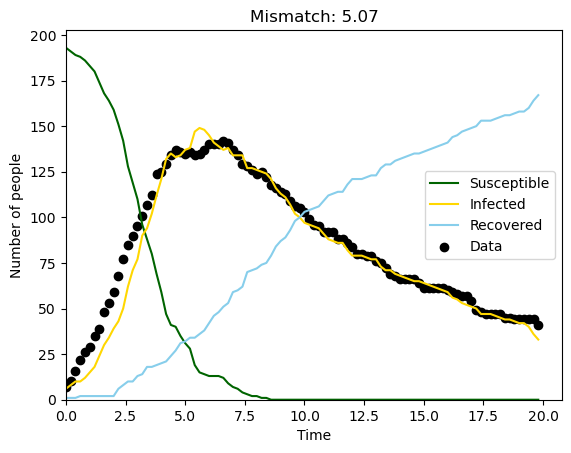

In [161]:
"""
Solution for tutorial 4.5 part 2
"""

import numpy as np
import sciris as sc
import pylab as pl

# EXERCISE 4 of 4 (do last): find parameters that match the data
beta = 0.15
dur_inf = 10
seed = 1

# Set default parameters
default_pars = sc.objdict(
    beta = beta, # Infection rate per contact per unit time
    dur_inf = dur_inf, # Average time of infection
    n_contacts = 5, # Number of people each person is connected to
    I0 = 5, # Number of people initially infected
    N = 200, # Total population size
    maxtime = 20, # How long to simulate for
    dt = 0.2, # Size of the timestep
    seed = seed, # Random seed to use
    colors = sc.objdict(S='darkgreen', I='gold', R='skyblue'),
)


# Define the data -- from sim.I.astype(int)
data = np.array(
[ 7,  10,  16,  22,  26,  29,  35,  39,  48,  53,  59,  68,  77,
 85,  90,  95, 101, 107, 112, 124, 125, 129, 134, 137, 136, 135,
136, 134, 135, 137, 140, 140, 140, 142, 141, 137, 134, 129, 128,
126, 124, 125, 122, 118, 116, 114, 113, 109, 106, 105, 103,  99,
 96,  95,  92,  92,  92,  88,  88,  86,  84,  80,  80,  79,  79,
 76,  75,  72,  69,  68,  66,  66,  66,  66,  64,  61,  61,  61,
 61,  61,  60,  59,  58,  57,  57,  54,  49,  48,  47,  47,  47,
 47,  45,  45,  44,  44,  44,  44,  44,  41]
)
time = np.arange(len(data))*default_pars.dt


class Person(sc.dictobj):
    """
    Define each person (agent) in SimpleABM

    They have three (mutually exclusive) states: susceptible (S), infected (I),
    recovered (R). They also have x,y coordinates for plotting.
    """

    def __init__(self, pars):
        self.pars = pars
        self.S = True # People start off susceptible
        self.I = False
        self.R = False

    def infect(self):
        self.S = False
        self.I = True

    def recover(self):
        self.I = False
        self.R = True

    def check_infection(self, other):
        pars = self.pars
        if self.S: # A person must be susceptible to be infected
            if other.I: # The other person must be infectious
                if np.random.rand() < pars.beta*pars.dt: # Infection is probabilistic
                    self.infect()

    def check_recovery(self):
        pars = self.pars
        if self.I: # A person must be infected to recover
            if np.random.rand() < pars.dt/pars.dur_inf: # Recovery is also probabilistic
                self.recover()


class Sim(sc.dictobj):
    """
    Define the simulation
    """

    def __init__(self, **kwargs):
        pars = sc.mergedicts(default_pars, kwargs) # Parameters to use
        pars.npts = int(pars.maxtime/pars.dt) # Number of points
        self.T = np.arange(pars.npts)
        self.time = self.T*pars.dt
        self.pars = pars
        self.initialize()

    def initialize(self):
        """ Initialize everything (sim can be re-initialized as well) """
        pars = self.pars

        # Initilaize people and the network
        np.random.seed(pars.seed)
        self.people = [Person(pars) for i in range(pars.N)] # Create all the people
        for person in self.people[0:pars.I0]: # Make the first I0 people infectious
            person.infect() # Set the initial conditions
        self.make_network()

        # Initial conditions
        self.S = np.zeros(pars.npts)
        self.I = np.zeros(pars.npts)
        self.R = np.zeros(pars.npts)
        self.S_full = []
        self.I_full = []
        self.R_full = []

    def make_network(self):
        """ Create a random network """
        pars = self.pars
        self.contacts = []
        for i in range(pars.N):
            partners = np.random.randint(pars.N, size=pars.n_contacts)
            pairs = [[i,j] for j in partners if i != j]
            self.contacts.extend(pairs)

    def check_infections(self):
        """ Check which agents become infected """
        for p1,p2 in self.contacts:
            person1 = self.people[p1]
            person2 = self.people[p2]
            person1.check_infection(person2)
            person2.check_infection(person1)

    def check_recoveries(self):
        """ Check which agents recover """
        for person in self.people:
            person.check_recovery()

    def count(self, t):
        """ Count the number of agents in each state """
        this_S = []
        this_I = []
        this_R = []
        for i,person in enumerate(self.people):
            if person.S: this_S.append(i)
            if person.I: this_I.append(i)
            if person.R: this_R.append(i)

        self.S[t] += len(this_S)
        self.I[t] += len(this_I)
        self.R[t] += len(this_R)

    def run(self):
        """ Run the simulation by integrating over time """
        for t in self.T:
            self.check_infections() # Check which infectious occur
            self.check_recoveries() # Check which recoveries occur
            self.count(t) # Store results
        self.check_mismatch() # Check the mismatch at the end of the run
    
    # EXERCISE 1 of 4: define average mismatch
    def check_mismatch(self):
        self.mismatch = abs(data - self.I).mean() # Mean absolute difference of data and number of people infected

    def best_par(self):
        beta_grid = np.arange(10) / 10
        dur_inf_grid = np.arange(10)

        mm = np.zeros((10, 10))  # Assuming you want a 2D array to store values

        for i in range(100):
            for j in range(100):
                sim = Sim(beta=beta_grid[i], dur_inf=dur_inf_grid[j])
                mm[i, j] = self.check_mismatch()  # Append the mismatch value to the correct index of mm
                print(self.check_mismatch())


        

        




    def plot(self):
        """ Plot numbers of S, I, R over time """
        pl.figure()
        cols = self.pars.colors
        pl.plot(self.time, self.S, label='Susceptible', c=cols.S)
        pl.plot(self.time, self.I, label='Infected', c=cols.I)
        pl.plot(self.time, self.R, label='Recovered', c=cols.R)
        
        # EXERCISE 2 of 4: add the data to the plot
        pl.scatter(time, data, c='k', label='Data')
        
        pl.legend()
        pl.xlabel('Time')
        pl.ylabel('Number of people')
        
        # EXERCISE 3 of 4: add the goodness of fit/mismatch as a title to the plot
        pl.title(f'Mismatch: {self.mismatch:n}')
        
        pl.ylim(bottom=0)
        pl.xlim(left=0)
        pl.show()



if __name__ == '__main__':

    # Create and run the simulation
    sim = Sim(beta = 0.140125, dur_inf = 9.9)
    sim.run()
    sim.plot()



In [111]:
import numpy as np

beta_grid = np.arange(100) / 100
dur_inf_grid = np.arange(100)

mm = np.zeros((100, 100))  # Assuming you want a 2D array to store values

for i in range(100):  # Adjusted the loop range to match the grid size
    for j in range(100):  # Adjusted the loop range to match the grid size
        sim = Sim(beta=beta_grid[i], dur_inf=dur_inf_grid[j])
        sim.run()
        mm[i, j] = sim.check_mismatch()
        mm[i, j] = int(sim.mismatch)
        

/var/folders/r5/zjynl38s3l96dpybh82qbs_r0000gn/T/ipykernel_66095/2699498785.py:74: RuntimeWarning: divide by zero encountered in divide
  if np.random.rand() < pars.dt/pars.dur_inf: # Recovery is also probabilistic


In [112]:
mm

array([[83., 83., 82., ..., 78., 78., 78.],
       [83., 83., 82., ..., 74., 74., 74.],
       [83., 83., 82., ..., 60., 60., 60.],
       ...,
       [83., 85., 81., ..., 92., 92., 92.],
       [83., 84., 81., ..., 92., 92., 92.],
       [83., 84., 81., ..., 92., 92., 92.]])

In [113]:
# Find the indices of the minimum value
min_index = np.unravel_index(np.argmin(mm), mm.shape)

# Print the row and column indices
print("Row index of minimum value:", min_index[0])
print("Column index of minimum value:", min_index[1])

Row index of minimum value: 16
Column index of minimum value: 11


In [114]:
print(f'best beta: {beta_grid[16]} | best dur_inf: {dur_inf_grid[11]}')

best beta: 0.16 | best dur_inf: 11


In [130]:
# using scipy mimimizer:
from scipy.optimize import minimize, LinearConstraint

b = np.arange(100) / 100
d = np.arange(100)
#constraint = LinearConstraint(np.ones(b), lb=0, ub=1)

def objective_function(b, d):
    sim = Sim(beta=b, dur_inf=d)
    sim.run()
    mm = sim.check_mismatch()
    mm = int(sim.mismatch)
    return mm



In [159]:
import scipy.optimize as optimize

def f(params):
    # print(params)  # <-- you'll see that params is a NumPy array
    b, d = params # <-- for readability you may wish to assign names to the component variables
    sim = Sim(beta=b, dur_inf=d)
    sim.run()
    mm = sim.check_mismatch()
    mm = (sim.mismatch)
    print(b, d, mm)
    return mm

initial_guess = [.19, 11]
# result = optimize.minimize(f, initial_guess, )
result = sc.asd(f, initial_guess)


0.19 11.0 9.26
0.20900000000000002 11.0 9.4
     step 1 (0.0 s) -- (orig:9.260 | best:9.260 | new:9.400 | diff:0.1400)
0.17099999999999999 11.0 8.33
     step 2 (0.1 s) ++ (orig:9.260 | best:9.260 | new:8.330 | diff:-0.9300)
0.13299999999999998 11.0 7.06
     step 3 (0.1 s) ++ (orig:9.260 | best:8.330 | new:7.060 | diff:-1.270)
0.05699999999999997 11.0 43.18
     step 4 (0.2 s) -- (orig:9.260 | best:7.060 | new:43.18 | diff:36.12)
0.09499999999999997 11.0 13.65
     step 5 (0.2 s) -- (orig:9.260 | best:7.060 | new:13.65 | diff:6.590)
0.13299999999999998 12.1 10.46
     step 6 (0.3 s) -- (orig:9.260 | best:7.060 | new:10.46 | diff:3.400)
0.13299999999999998 11.55 9.94
     step 7 (0.3 s) -- (orig:9.260 | best:7.060 | new:9.940 | diff:2.880)
0.11399999999999998 11.0 17.56
     step 8 (0.3 s) -- (orig:9.260 | best:7.060 | new:17.56 | diff:10.50)
0.13299999999999998 9.9 6.84
     step 9 (0.4 s) ++ (orig:9.260 | best:7.060 | new:6.840 | diff:-0.2200)
0.1425 9.9 6.41
     step 10 (0.4 s) ++ 

In [160]:
result

#0. 'x':          array([0.140125, 9.9     ])
————————————————————————————————————————
#1. 'fval':       5.07
————————————————————————————————————————
#2. 'exitreason': 'Absolute improvement too small (0 < 0.000001000)'
————————————————————————————————————————
#3. 'details':
    #0. 'fvals':
    array([9.26, 9.26, 8.33, 7.06, 7.06, 7.06, 7.06, 7.06, 7.06, 6.84, 6.41,
           6.41, 6.22, 6.22, 6.22, 6.22, 6.22, 6.22, 5.89, 5.89, 5.34, 5.34,
           5.34, 5.34, 5.34, 5.07, 5.07, 5.07, 5.07, 5.07, 5.07, 5.07, 5.07,
           5.07, 5.07, 5.07, 5.07, 5.07, 5.07, 5.07, 5.07, 5.07, 5.07, 5.07,
           5.07, 5.07])
    #1. 'xvals':
    array([[ 0.19    , 11.      ],
           [ 0.19    , 11.      ],
           [ 0.171   , 11.      ],
           [ 0.133   , 11.      ],
           [ 0.133   , 11.      ],
           [ 0.133   , 11.      ],
           [ 0.133   , 11.      ],
           [ 0.133   , 11.      ],
           [ 0.133   , 11.      ],
           [ 0.133   ,  9.9     ],
        

In [150]:
import scipy.optimize as optimize

def f(params):
    # print(params)  # <-- you'll see that params is a NumPy array
    a, b, c = params # <-- for readability you may wish to assign names to the component variables
    return a**2 + b**2 + c**2

initial_guess = [2, 5, 2]
result = optimize.minimize(f, initial_guess)
if result.success:
    fitted_params = result.x
    print(fitted_params)
else:
    raise ValueError(result.message)

[-1.27028676e-09 -6.56702541e-08 -1.27028654e-09]


In [151]:
result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 4.315809533012237e-15
        x: [-1.270e-09 -6.567e-08 -1.270e-09]
      nit: 3
      jac: [ 1.236e-08 -1.164e-07  1.236e-08]
 hess_inv: [[ 9.394e-01 -1.515e-01 -6.061e-02]
            [-1.515e-01  6.212e-01 -1.515e-01]
            [-6.061e-02 -1.515e-01  9.394e-01]]
     nfev: 16
     njev: 4

In [ ]:
if result.success:
    fitted_params = result.x
    print(fitted_params)
else:
    raise ValueError(result.message)

In [133]:
res = minimize(
    objective_function,
    x0 = 10 * np.random.random(100),
    args=(b,),
    #constraints=constraint
)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## Problem 3

Now we will calibrate Starsim to the same data.

In [ ]:
"""
Problem for tutorial 4.5 part 3
"""

import numpy as np
import sciris as sc
import starsim as ss
import pylab as pl

# EXERCISE 5 of 5: find parameters that match the data
beta = 0.3
dur_inf = 2
seed = 1

# Define the colors
colors = sc.objdict(S='darkgreen', I='gold', R='skyblue')

pars = sc.objdict(
    n_agents = 200,
    start = 0,
    end = 20,
    dt = 0.2,
    diseases = dict(
        type = 'sir',
        beta = beta,
        dur_inf = ss.expon(scale=dur_inf),
        init_prev = 5/200,
        p_death = 0,
    ),
    networks = dict(
        type = 'static',
        n_contacts = 5,
    ),
    rand_seed = seed,
)


# Define the data
data = np.array(
[ 6,  11,  14,  15,  17,  20,  25,  31,  40,  47,  52,  57,  66,
 75,  85,  93,  99, 100, 107, 111, 112, 118, 123, 117, 120, 122,
122, 123, 123, 125, 122, 120, 119, 110, 112, 117, 115, 118, 117,
113, 115, 112, 111, 107, 105, 103, 101,  99, 100,  99,  98,  97,
 94,  93,  92,  91,  89,  88,  88,  87,  86,  83,  81,  80,  78,
 76,  76,  73,  72,  71,  71,  71,  69,  68,  67,  65,  61,  58,
 57,  56,  56,  54,  52,  51,  51,  49,  49,  47,  46,  46,  46,
 46,  45,  45,  45,  43,  43,  40,  37,  36]
)
time = np.arange(len(data))*pars.dt


class check_mismatch(ss.Analyzer):
    def finalize(self, sim):
        self.sim = sim # Used for plotting
        res = sim.diseases.sir.results

        # EXERCISE 1 of 5: compute the mismatch
        self.mismatch = res.n_infection - 

    
    def plot(self):
        """ Plot numbers of S, I, R over time """
        pl.figure()
        res = self.sim.diseases.sir.results
        tvec = self.sim.yearvec

        # EXERCISE 2 of 5: plot results from Starsim
        pl.plot(tvec, res.n_susceptible, label='Susceptible', c=colors.S) # Plot susceptibles
        pl.plot(...) # Plot infected
        pl.plot(...) # Plot recovered
        
        # EXERCISE 3 of 5: add the data to the plot
        pl.scatter(...)

        # Add legend and labels
        pl.legend()
        pl.xlabel('Time')
        pl.ylabel('Number of people')
        
        # EXERCISE 4 of 5: add the goodness of fit/mismatch as a title to the plot
        pl.title(...)
        
        pl.ylim(bottom=0)
        pl.xlim(left=0)
        pl.show()


if __name__ == '__main__':

    # Create and run the simulation
    check_mismatch = check_mismatch()
    sim = ss.Sim(pars, analyzers=check_mismatch)
    sim.run()
    check_mismatch.plot()

## Solution 3

In [ ]:
"""
Solution for tutorial 4.5 part 3
"""

import numpy as np
import sciris as sc
import starsim as ss
import pylab as pl

# EXERCISE 5 of 5: find parameters that match the data
beta = 0.35 # NB: best-fitting beta is not the same as in simple_abm!
dur_inf = 10 # However, dur_inf is
seed = 1

# Define the colors
colors = sc.objdict(S='darkgreen', I='gold', R='skyblue')

pars = sc.objdict(
    n_agents = 200,
    start = 0,
    end = 20,
    dt = 0.2,
    diseases = dict(
        type = 'sir',
        beta = beta,
        dur_inf = ss.expon(scale=dur_inf),
        init_prev = 5/200,
        p_death = 0,
    ),
    networks = dict(
        type = 'static',
        n_contacts = 5,
    ),
    rand_seed = seed,
)


# Define the data
data = np.array(
[ 6,  11,  14,  15,  17,  20,  25,  31,  40,  47,  52,  57,  66,
 75,  85,  93,  99, 100, 107, 111, 112, 118, 123, 117, 120, 122,
122, 123, 123, 125, 122, 120, 119, 110, 112, 117, 115, 118, 117,
113, 115, 112, 111, 107, 105, 103, 101,  99, 100,  99,  98,  97,
 94,  93,  92,  91,  89,  88,  88,  87,  86,  83,  81,  80,  78,
 76,  76,  73,  72,  71,  71,  71,  69,  68,  67,  65,  61,  58,
 57,  56,  56,  54,  52,  51,  51,  49,  49,  47,  46,  46,  46,
 46,  45,  45,  45,  43,  43,  40,  37,  36]
)
time = np.arange(len(data))*pars.dt


class check_mismatch(ss.Analyzer):
    def finalize(self, sim):
        self.sim = sim # Used for plotting
        res = sim.diseases.sir.results

        # EXERCISE 1 of 5: compute the mismatch
        self.mismatch = abs(data - res.n_infected[:len(data)]).mean()
    
    def plot(self):
        """ Plot numbers of S, I, R over time """
        pl.figure()
        res = self.sim.diseases.sir.results
        tvec = self.sim.yearvec

        # EXERCISE 2 of 5: plot results from Starsim
        pl.plot(tvec, res.n_susceptible, label='Susceptible', c=colors.S)
        pl.plot(tvec, res.n_infected, label='Infected', c=colors.I)
        pl.plot(tvec, res.n_recovered, label='Recovered', c=colors.R)
        
        # EXERCISE 3 of 5: add the data to the plot
        pl.scatter(time, data, c='k', label='Data')

        # Add legend and labels
        pl.legend()
        pl.xlabel('Time')
        pl.ylabel('Number of people')
        
        # EXERCISE 4 of 5: add the goodness of fit/mismatch as a title to the plot
        pl.title(f'Mismatch: {self.mismatch:n}')
        
        pl.ylim(bottom=0)
        pl.xlim(left=0)
        pl.show()


if __name__ == '__main__':

    # Create and run the simulation
    check_mismatch = check_mismatch()
    sim = ss.Sim(pars, analyzers=check_mismatch)
    sim.run()
    check_mismatch.plot()